# Imputation



# Useful Links
- cifar ex https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/cifar10_bnn.py
- uses resnet https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/models/bayesian_resnet.py
- http://krasserm.github.io/2019/03/14/bayesian-neural-networks/
- https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py



In [7]:
# User defined paths
matrix_path = "/home/eecs/akmorrow/epitome/data/imputed_numpy_dict_v.npy"
new_validation_path = "/home/eecs/akmorrow/epitome/data/new_validation.npy"

# where to save temporary models to
checkpoint_path = "/home/eecs/akmorrow/epitome/out/models"

plot_dir = "/home/eecs/akmorrow/epitome/out/tmp/figures"
results_path = "/home/eecs/akmorrow/epitome/out/tmp"

# iterations to run models
model_iterations = 5000
validation_size = 4000

In [8]:
from epitome.constants import *
from epitome.models import *
from epitome.generators import *
from epitome.functions import *
from epitome.viz import *
from sklearn.metrics import roc_curve, auc
assert(tf.executing_eagerly())
import tensorflow_probability as tfp
import yaml

/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [9]:
# load in user paths
# TODO: make a config file with data_path (downloaded from bin/download_deepsea_data.py) 
# and feature_name_file (at data/feature_name)
# My config.yml looks like:
# data_path: /data/akmorrow/epitome_data/numpy_data/
# feature_name_file: /home/eecs/akmorrow/epitome/data/feature_name

with open('/home/eecs/akmorrow/epitome/config.yml') as f:
    config = yaml.safe_load(f)
    
train_data, valid_data, test_data = load_deepsea_label_data(config["data_path"])
data = {Dataset.TRAIN: train_data, Dataset.VALID: valid_data, Dataset.TEST: test_data}
print(data[Dataset.TRAIN].shape, data[Dataset.VALID].shape, data[Dataset.TEST].shape)

(919, 2200000) (919, 4000) (919, 227512)


## Plot Data Matrix

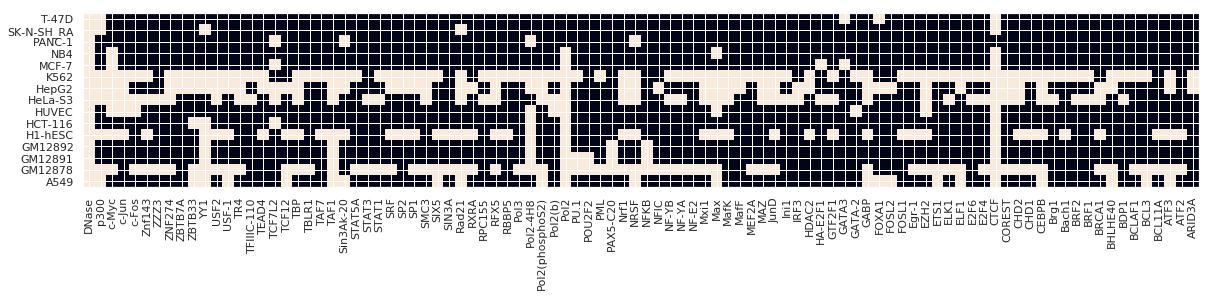

In [67]:
eligible_assays = ['DNase',
 'p300',
 'c-Myc',
 'ZNF274',
 'USF2',
 'TR4',
 'TBP',
 'TAF1',
 'SMC3',
 'Rad21',
 'RFX5',
 'Pol2(phosphoS2)',
 'Pol2',
 'Nrf1',
 'NRSF',
 'Mxi1',
 'Max',
 'MAZ',
 'JunD',
 'GABP',
 'EZH2',
 'CTCF',
 'COREST',
 'CHD2',
 'CEBPB']

matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = None,
                                  eligible_cells = None, min_cells_per_assay = 2, min_assays_per_cell=5)

nv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=Label.UNK.value)

# Original Model

Run original model on first 10,000 datapoints. The predict validation set for all cells. Results can be compared to fancy imputation.

In [15]:
model_new = MLP(data,
            [],
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            batch_size=64)
model_new.train(model_iterations)


I0731 15:27:38.869211 140224757253888 models.py:189] Starting Training


eval cell types ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0731 15:27:40.138683 140224757253888 models.py:208] 0 tf.Tensor(0.007428934, shape=(), dtype=float32)


CPU times: user 2.21 s, sys: 222 ms, total: 2.43 s
Wall time: 1.81 s


In [16]:
validation_celltypes =  ['K562', 'HepG2', 'HeLa-S3', 'GM12878']

In [17]:

_, g = generator_to_tf_dataset(load_data(data[Dataset.VALID], 
                                               validation_celltypes, 
                                               model_new.eval_cell_types,
                                               model_new.matrix,
                                               model_new.assaymap,
                                               model_new.cellmap,
                                               radii = model_new.radii, mode = Dataset.VALID),
                                               model_new.batch_size, 1, model_new.prefetch_size)
results_original = model_new.test_from_generator(validation_size * len(validation_celltypes), g)
np.save(os.path.join(results_path, "results_original.npy"), results_original, allow_pickle=True)

using ['K562', 'HepG2', 'HeLa-S3', 'GM12878'] as labels for mode Dataset.VALID


I0731 15:27:41.056215 140224757253888 models.py:357] macro auROC:     0.6671866331098348
I0731 15:27:41.057050 140224757253888 models.py:358] auPRC:     0.3243754705955784
I0731 15:27:41.057737 140224757253888 models.py:359] GINI:     0.3045154037672709


# Curriculum learning

1. initialize missing labels for train (v)
2. train BNN with partial labels
3. Repeat until no data is missing:
    - update v with easy labels. For now, easy labels are defined as getting close to 0 or 1 by distance theta
    - retrain w on new dataset


In [152]:

def load_v_data(data, 
                 label_cell_types,  # used for labels. Should be all for train/eval and subset for test
                 eval_cell_types,   # used for rotating features. Should be all - test for train/eval
                 matrix,
                 assaymap,
                 cellmap,
                 radii,
                 **kwargs):
    
    # AM 5/20/2019. This is enforcing exclusive DNase bins and will make 
    # interpretation of DNase weights easier. It does not add performance benefit
    # over inclusive bins, which was used in the original model.
    exclusive = True

    """
    Takes Deepsea data and calculates distance metrics from cell types whose locations
    are specified by label_cell_indices, and the other cell types in the set. Label space is only one cell type.
     TODO AM 3/7/2019
    :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n by 919 labels.
    :param label_cell_types: list of cell types to be rotated through and used as labels (subset of eval_cell_types)
    :param eval_cell_types: list of cell types to be used in evaluation (includes label_cell_types)
    :param matrix: matrix of celltype, assay positions
    :param assaymap: map of column assay positions in matrix
    :param cellmap: map of row cell type positions in matrix
    :param radii: radii to compute dnase distances from
    :param kwargs: kargs

    :returns: generator of data with three elements:
        1. record features
        2. record labels for a given cell type
        3. 0/1 mask of labels that have validation data. For example, if this record is for celltype A549,
        and A549 does not have data for ATF3, there will be a 0 in the position corresponding to the label space.
    """
    # set all UNKs features to TF mean
    def TF_mean(i, idx, cell_indices):
        """
        Gets the mean TF binding score for an element in this location
        """
        # compute means at row i in data for all assays
        indices = matrix[cell_indices,:].T.flatten()
        tmp1 = data[:,i][indices].astype(None)
        tmp1[tmp1 == Label.UNK.value] = np.nan
        tmp1[tmp1 == Label.IMPUTED_BOUND.value] = Label.BOUND.value
        tmp1[tmp1 == Label.IMPUTED_UNBOUND.value] = Label.UNBOUND.value
        means = np.nanmean(tmp1.reshape([len(cell_indices),  matrix.shape[1]]), axis=0) 
        
        TF_idx = idx % matrix.shape[1]
        return means[TF_idx]

    # Running in TRAIN, VALID, or TEST?    
    mode = kwargs.get("mode")
    # specifies the indices to generate records.
    # can be used for debug purposes, or to evaluate
    # only specific regions in a vector
    # TODO AM 4/17/2019: move this to an actual parameter
    indices = kwargs.get("indices")
    
    if (not isinstance(indices, np.ndarray) and not isinstance(indices, list)):
        indices = range(0, data.shape[-1]) # if not defined, set to all points
    
    if (not isinstance(mode, Dataset)):
        raise ValueError("mode is not a Dataset enum")
        
    if (mode == Dataset.RUNTIME):
        label_cell_types = ["PLACEHOLDER_CELL"]
        dnase_vector = kwargs.get("dnase_vector")
        random_cell = list(cellmap)[0] # placeholder to get label vector length
        
    print("using %s as labels for mode %s" % (label_cell_types, mode))
    
    # string of radii for meta data labeling
    radii_str = list(map(lambda x: "DNASE_RADII_%i" % x, radii))
        
    if (mode == Dataset.TEST or mode == Dataset.RUNTIME):
        # Drop cell types with the least information (TODO AM 4/1/2019 this could do something smarter)
        
        # make dictionary of eval_cell_type: assay count and sort in decreasing order
        tmp = matrix.copy()
        tmp[tmp >= Label.UNBOUND.value] = 1
        tmp[tmp == Label.UNK.value] = 0 
        sums = np.sum(tmp, axis = 1)
        cell_assay_counts = zip(list(cellmap), sums)
        cell_assay_counts = sorted(cell_assay_counts, key = lambda x: x[1])
        # filter by eval_cell_types
        cell_assay_counts = list(filter(lambda x: x[0] in eval_cell_types, cell_assay_counts))
        
        # remove cell types with smallest number of factors
        eval_cell_types = eval_cell_types.copy()
        [eval_cell_types.remove(i[0]) for i in cell_assay_counts[0:len(label_cell_types)]]
        del tmp
        del cell_assay_counts
        
        
    def g():
        for i in indices: # for all records specified
            for (cell) in label_cell_types: # for all cell types to be used in labels
                dnases = [] 
                dnases_double_positive = []
                dnases_agreement = []
                
                # cells to be featurized
                feature_cells = eval_cell_types.copy()
                
                # try to remove cell if it is in the possible list of feature cell types
                try:
                    feature_cells.remove(cell) 
                except ValueError:
                    pass  # do nothing!
                                
                # features from all remaining cells not in label set
                feature_cell_indices_list = list(map(lambda c: get_y_indices_for_cell(matrix, cellmap, c), 
                                                     feature_cells))
                feature_cell_indices = np.array(feature_cell_indices_list).flatten()
                
                                
                # labels for this cell
                if (mode != Dataset.RUNTIME):
                    label_cell_indices = get_y_indices_for_cell(matrix, cellmap, cell)
                    label_cell_indices_no_dnase = np.delete(label_cell_indices, [0])
                    labels = data[label_cell_indices_no_dnase,i]

                    # Copy assay_index_no_dnase and turn into mask of 0/1 for whether data for this cell type for
                    # a given label is available.
                    assay_mask = np.ones(labels.shape)
                    # set mask over missing AND imputed mask
                    assay_mask[labels < Label.UNBOUND.value] = 0
                else:
                    label_count = len(get_y_indices_for_cell(matrix, cellmap, random_cell))-1
                    
                    # Mask and labels are all 0's because labels are missing during runtime
                    garbage_labels = assay_mask = np.zeros(label_count)
                    # The features going into the example.
                    labels = garbage_labels # all 0's

                # get dnase indices for cell types that are going to be features
                dnase_indices = np.array([x[0] for x in feature_cell_indices_list])
                
                for r, radius in enumerate(radii):
                    
                    min_radius = max(0, i - radius + 1)
                    max_radius = min(i+radius, data.shape[1])
                    
                    # if exclusive == True, then do not featurize chromatin regions
                    # that were considered in smaller radii
                    if (exclusive and r != 0):
                        radius_range_1 = np.arange(min_radius, max(0, i - radii[r-1]+1))
                        radius_range_2 = np.arange(i+radii[r-1], max_radius)
                        
                        radius_range = np.concatenate([radius_range_1, radius_range_2])
                    else:
                        
                        radius_range = np.arange(min_radius, max_radius)
                        
                        
                    ####################################################################
                    
                    # use DNase vector, if it is provided
                    if (mode == Dataset.RUNTIME):

                        # within the radius, fraction of places where they are both 1
                        dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
                                                 dnase_vector[radius_range], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
                                                 dnase_vector[radius_range], axis=1)

                    else:
                        # within the radius, fraction of places where they are both 1
                        # label_cell_index[0] == DNase location for specific cell type
                        dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
                                                 data[label_cell_indices[0],radius_range], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
                                                 data[label_cell_indices[0],radius_range], axis=1)
                        
                    dnases_double_positive.extend(dnase_double_positive)
                    dnases_agreement.extend(dnase_agreement)
                        
                # rehape agreement DNase to Radii by feature_cells
                dnases_agreement_reshaped = np.array(dnases_agreement).reshape([len(radii), len(feature_cells)])
                dnases_double_positive_reshaped = np.array(dnases_double_positive).reshape([len(radii), len(feature_cells)])
                dnase_means = np.mean(dnases_agreement_reshaped, axis = 0)

                ######### reorder cells by similarity ################
                ## This was added 5/30/2019. It seems to *maybe help 
                ## a little bit on cell types not seen in the model.
                ## This makes sense because cell types are now ordered
                ## by similarity and keep some spacial positioning 
                ## based on the similarity to the new cell. 
                best_indices = (-dnase_means).argsort()

                dnases.extend(dnases_double_positive_reshaped[:,best_indices].flatten())
                dnases.extend(dnases_agreement_reshaped[:,best_indices].flatten())

                feature_cell_indices = feature_cell_indices.reshape([len(feature_cells), len(assaymap)])[best_indices,:].flatten()
                ######## End reorder #################################                                                   
                                                                        
                                                                        
                # Extract features
                features = data[feature_cell_indices,i]
                # concatenate features and DNases
                x_data = np.concatenate([features, dnases])
                
                # mask for x_data. 0 = do not mask, 1 = mask.
                x_mask = np.zeros(x_data.shape[0])
                # mask imputed (bound and unbound) and missing features
                x_mask[np.where(features == Label.UNK.value)[0]] = True # assign mask to missing features

                # There can be NaNs in the DNases for edge cases (when the radii extends past the end of the chr).
                # Mask these values in the first row of tmp
                x_mask[np.where(np.isnan(x_data))[0]] = True # assign mask to missing DNase values
                x_data[np.where(x_mask == True)[0]] = 0 # set all UNKs to 0
                
                # reset imputed values to normal known values in x_data
                x_data[np.where(x_data == Label.IMPUTED_BOUND.value)[0]] = Label.BOUND.value 
                x_data[np.where(x_data == Label.IMPUTED_UNBOUND.value)[0]] = Label.UNBOUND.value 

                
                
                # recalculate missing values as means
                masked_indices = np.where(x_mask == True)[0][:len(feature_cell_indices)]
                cellmap_idx = list(map(lambda x: cellmap[x], feature_cells))
                # TODO this is an issue. GIving back NaNs
#                 x_data[masked_indices] = TF_mean(i, masked_indices, cellmap_idx)
                
#                 x_data_masked = np.vstack([x_mask, x_data]) # top row 0 = mask, bottom row 1 = data
                yield (x_data, labels, assay_mask)

    return g



# VLP

In [160]:
import tqdm 
import tensorflow_probability as tfp

class VariationalPeakModel():
    def __init__(self,
                 data,
                 test_celltypes,
                 matrix,
                 assaymap,
                 cellmap,  
                 debug = False,
                 batch_size=64,
                 shuffle_size=10,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3,10,30], 
                 train_indices = None):
        
        """
        Peak Model
        :param data: either a path to TF records OR a dictionary of TRAIN, VALID, and TEST data
        :param test_celltypes
        :param matrix
        :param assaymap
        :param cellmap
        :param debug: used to print out intermediate validation values
        :param batch_size
        :param shuffle_size
        :param prefetch_size
        :param l1
        :param l2
        :param lr
        :param radii
        :param train_indices: option numpy array of indices to train from data[Dataset.TRAIN]
        """
        
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

        assert (set(test_celltypes) < set(list(cellmap))), \
                "test_celltypes %s must be subsets of available cell types %s" % (str(test_celltypes), str(list(cellmap)))

        # get evaluation cell types by removing any cell types that would be used in test
        self.eval_cell_types = list(cellmap).copy()
        self.test_celltypes = test_celltypes
        [self.eval_cell_types.remove(test_cell) for test_cell in self.test_celltypes]
        print("eval cell types", self.eval_cell_types)
        self.output_shape, self.train_iter = generator_to_tf_dataset(load_v_data(data[Dataset.TRAIN],  
                                                self.eval_cell_types,
                                                self.eval_cell_types,
                                                matrix,
                                                assaymap,
                                                cellmap,
                                                radii = radii, mode = Dataset.TRAIN),
                                                batch_size, shuffle_size, prefetch_size)

        _,            self.valid_iter = generator_to_tf_dataset(load_v_data(data[Dataset.VALID], 
                                                self.eval_cell_types,
                                                self.eval_cell_types,
                                                matrix,
                                                assaymap,
                                                cellmap,
                                                radii = radii, mode = Dataset.VALID), 
                                                batch_size, 1, prefetch_size)

        # can be empty if len(test_celltypes) == 0
        _,            self.test_iter = generator_to_tf_dataset(load_v_data(data[Dataset.TEST], 
                                               self.test_celltypes, 
                                               self.eval_cell_types,
                                               matrix,
                                               assaymap,
                                               cellmap,
                                               radii = radii, mode = Dataset.TEST),
                                               batch_size, 1, prefetch_size)

        self.num_outputs = self.output_shape[0]
        self.l1, self.l2 = l1, l2
        self.lr = lr
        self.batch_size = batch_size
        self.prefetch_size = prefetch_size
        self.shuffle_size = shuffle_size
        self.optimizer =tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr)

        # set self
        self.model = self.create_model()
        self.radii = radii
        self.debug = debug
        self.assaymap = assaymap
        self.test_celltypes = test_celltypes
        self.matrix = matrix
        self.assaymap= assaymap 
        self.cellmap = cellmap
        self.data = data
            
    def save(self, checkpoint_path):
        """
        Saves model.
        
        :param checkpoint_path: string file path to save model to. 
        """
        # save keras model
        self.model.save(checkpoint_path)
        
        # save model params to pickle file
        dict_ = {'test_celltypes':self.test_celltypes,
                         'matrix':self.matrix,
                         'assaymap':self.assaymap,
                         'cellmap':self.cellmap,  
                         'debug': self.debug,
                         'batch_size':self.batch_size,
                         'shuffle_size':self.shuffle_size,
                         'prefetch_size':self.prefetch_size,
                         'radii':self.radii}
        
        fileObject = open(os.path.join(checkpoint_path, "model_params.pickle"),'wb')
        pickle.dump(dict_,fileObject)   
        fileObject.close()
        
        
    def gini(self, actual, pred, sample_weight):                                                 
        df = sorted(zip(actual, pred), key=lambda x : (x[1], x[0]),  reverse=True)
        random = [float(i+1)/float(len(df)) for i in range(len(df))]                
        totalPos = np.sum([x[0] for x in df])           
        cumPosFound = np.cumsum([x[0] for x in df])                                     
        Lorentz = [float(x)/totalPos for x in cumPosFound]                          
        Gini = np.array([l - r for l, r in zip(Lorentz, random)])
        # mask Gini with weights
        Gini[np.where(sample_weight == 0)[0]] = 0
        return np.sum(Gini)    

    def gini_normalized(self, actual, pred, sample_weight = None):              
        normalized_gini = self.gini(actual, pred, sample_weight)/self.gini(actual, actual, sample_weight)      
        return normalized_gini       

    def body_fn(self):
        raise NotImplementedError()
        
    def g(self, p, a=1, B=0, y=1):
        """ Normalization Function. Normalizes loss w.r.t. label proportion.

        Constraints: 
         1. g(p) = 1 when p = 1
         2. g(p) = a * p^y + B, where a, y and B are hyperparameters
        """
        return a * tf.math.pow(p, y) + B
    
    def loss_fn(self, y_true, y_pred, weights):
        # weighted sum of cross entropy for non 0 weights
        # Reduction method = Reduction.SUM_BY_NONZERO_WEIGHTS
        
        y_true_bin = tf.multiply(weights, y_true) # 0 out -1 UNKs
        loss = tf.compat.v1.losses.sigmoid_cross_entropy(y_true_bin,  
                                                        y_pred, 
                                                        weights = weights,
                                                        reduction = tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS)

        C = (len(self.assaymap)-1)
        # p = tf.math.reduce_sum(weights, axis=1)/C # should be of dimension 1 by batch size
        p = 1.0 # this is just taking the mean loss, nothing special here.
        return self.g(p)/C * loss
    
    
    def train(self, num_steps, lr=None, checkpoint_path = None):
        if lr == None:
            lr = self.lr
            
        tf.compat.v1.logging.info("Starting Training")

        @tf.function
        def train_step(inputs, labels, weights):
            with tf.GradientTape() as tape:
                logits = self.model(inputs, training=True)
                kl_loss = sum(self.model.losses)
                neg_log_likelihood = self.loss_fn(labels, logits, weights)
                elbo_loss = neg_log_likelihood + kl_loss
            
            gradients = tape.gradient(elbo_loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            return elbo_loss, neg_log_likelihood, kl_loss

        for step, (inputs, labels, weights) in enumerate(self.train_iter.take(num_steps)): 

            loss = train_step(inputs, labels, weights)

            if step % 1000 == 0:
                tf.compat.v1.logging.info(str(step) + " " + str(tf.reduce_mean(loss[0])) + 
                                          str(tf.reduce_mean(loss[1])) +
                                          str(tf.reduce_mean(loss[2])))
                
                if (self.debug):
                    tf.compat.v1.logging.info("On validation")
                    _, _, _, _, _ = self.test(40000, log=False)
                    tf.compat.v1.logging.info("")

    def test(self, num_samples, mode = Dataset.VALID, calculate_metrics=False):
        """
        Tests model on valid and test dataset handlers.
        """

        if (mode == Dataset.VALID):
            handle = self.valid_iter # for standard validation of validation cell types
            
        elif (mode == Dataset.TEST and len(self.test_celltypes) > 0):
            handle = self.test_iter # for standard validation of validation cell types        
        else:
            raise Exception("No data exists for %s. Use function test_from_generator() if you want to create a new iterator." % (mode))
            
        return self.run_predictions(num_samples, handle, calculate_metrics)      
        
    def test_from_generator(self, num_samples, ds, calculate_metrics=True):
        """
        Runs test given a specified data generator 
        :param num_samples: number of samples to test
        :param ds: tensorflow dataset, created by dataset_to_tf_dataset
        :param cell_type: cell type to test on. Used to generate holdout indices.
        
        :return predictions
        """
        return self.run_predictions(num_samples, ds, calculate_metrics)
    
    def eval_vector(self, data, vector, indices):
        """
        Evaluates a new cell type based on its chromatin (DNase or ATAC-seq) vector. len(vector) should equal
        the data.shape[1]
        :param data: data to build features from 
        :param vector: vector of 0s/1s of binding sites TODO AM 4/3/2019: try peak strength instead of 0s/1s
        :param indices: indices of vector to actually score. You need all of the locations for the generator.

        :return predictions for all factors
        """
        
        _,  ds = generator_to_tf_dataset(load_data(data, 
                 self.test_celltypes,   # used for labels. Should be all for train/eval and subset for test
                 self.eval_cell_types,   # used for rotating features. Should be all - test for train/eval
                 self.matrix,
                 self.assaymap,
                 self.cellmap,
                 radii = self.radii,
                 mode = Dataset.RUNTIME,
                 dnase_vector = vector, indices = indices), self.batch_size, 1, self.prefetch_size)

        num_samples = len(indices)
        
        preds, _, _, _, _ = self.run_predictions(num_samples, ds, calculate_metrics = False)    
        
        return preds

    def run_predictions(self, num_samples, iter_, calculate_metrics = True, samples = 500):
        """
        Runs predictions on num_samples records
        :param num_samples: number of samples to test
        :param iter_: output of self.sess.run(generator_to_one_shot_iterator()), handle to one shot iterator of records
        :param alculate_metrics: if true, logs individual factor accuracies
        :param samples: number of times to sample from posterior distribution
        
        :return preds, truth, assay_dict, auROC, auPRC, False
            preds = predictions, 
            truth = actual values, 
            sample_weight: 0/1 weights on predictions.  
            assay_dict = if log=True, holds predictions for individual factors
            auROC = average macro area under ROC for all factors with truth values
            auPRC = average area under PRC for all factors with truth values
        """
        
        inv_assaymap = {v: k for k, v in self.assaymap.items()}
                        
        # batches of predictions
        vals = []

        # Calculate epistemic uncertainty by iterating over a certain number of times,
        # getting y_preds. You can then calculate the mean and sigma of the predictions, 
        # and use this to gather uncertainty: (see http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)
        # inputs, truth, sample_weight
        vals = [(i[0],i[1],i[2]) for i in iter_.take(int(num_samples / self.batch_size)+1)]
        
        inputs = np.concatenate([v[0] for v in vals])[:num_samples]
        truth = np.concatenate([v[1] for v in vals])[:num_samples]
        sample_weight = np.concatenate([v[2] for v in vals])[:num_samples]
    
        y_pred_list = []
        for i in tqdm.tqdm(range(samples)):
            
            y_pred = tf.sigmoid(self.model(inputs, training=False))
            y_pred_list.append(y_pred)
            
        preds = np.dstack(y_pred_list)

        preds_mean = np.mean(preds, axis=2)
        preds_std = np.std(preds, axis=2)
        
        # reset truth back to 0 to compute metrics
        # sample weights will rule these out anyways when computing metrics
        truth_reset = np.copy(truth)
        truth_reset[truth_reset < Label.UNBOUND.value] = 0 
                                           
        # do not continue to calculate metrics. Just return predictions and true values
        if (not calculate_metrics):
            return {
                'preds_mean': preds_mean,
                'preds_std': preds_std,
                'truth': truth,
                'weights': sample_weight,
                'assay_dict': None,
                'auROC': None, 
                'auPRC': None
            }
        
        assert(preds_mean.shape == sample_weight.shape)

        try:
            # Mean results because sample_weight mask can only work on 1 row at a time.
            # If a given assay is not available for evaluation, sample_weights will all be 0 
            # and the resulting roc_auc_score will be NaN.
            auROC_vec = []
            auPRC_vec = []
            GINI_vec =  []


            # try/accept for cases with only one class (throws ValueError)
            assay_dict = {}

            for j in range(preds.shape[1]): # for all assays
                assay = inv_assaymap[j+1] 

                roc_score = np.NAN

                try:
                    roc_score = sklearn.metrics.roc_auc_score(truth_reset[:,j], preds_mean[:,j], 
                                                      average='macro', 
                                                      sample_weight = sample_weight[:,j])

                    auROC_vec.append(roc_score)

                except ValueError:
                    roc_score = np.NaN

                try:
                    pr_score = sklearn.metrics.average_precision_score(truth_reset[:,j], preds_mean[:,j], 
                                                             sample_weight = sample_weight[:, j])

                    auPRC_vec.append(pr_score)

                except ValueError:
                    pr_score = np.NaN

                try:
                    gini_score = self.gini_normalized(truth_reset[:,j], preds_mean[:,j], 
                                                      sample_weight = sample_weight[:, j])

                    GINI_vec.append(gini_score)

                except ValueError:
                    gini_score = np.NaN

                assay_dict[assay] = {"AUC": roc_score, "auPRC": pr_score, "GINI": gini_score }


            auROC = np.nanmean(auROC_vec)
            auPRC = np.nanmean(auPRC_vec)

            tf.compat.v1.logging.info("macro auROC:     " + str(auROC))
            tf.compat.v1.logging.info("auPRC:     " + str(auPRC))
            tf.compat.v1.logging.info("GINI:     " + str(np.nanmean(GINI_vec)))
        except ValueError as v:
            auROC = None
            auPRC = None
            tf.compat.v1.logging.info("Failed to calculate metrics")

        return {
            'preds_mean': preds_mean,
            'preds_std': preds_std,
            'truth': truth,
            'weights': sample_weight,
            'assay_dict': assay_dict,
            'auROC': auROC, 
            'auPRC': auPRC
        }
    
        
    def score_peak_file(self, peak_file):
    
        # get peak_vector, which is a vector matching train set. Some peaks will not overlap train set, 
        # and their indices are stored in missing_idx for future use
        peak_vector, all_peaks = bedFile2Vector(peak_file)
        print("finished loading peak file")

        # only select peaks to score
        idx = np.where(peak_vector == 1)[0]
        
        if len(idx) == 0:
            raise ValueError("No positive peaks found in %s" % peak_file)

        all_data = np.concatenate((self.data[Dataset.TRAIN], self.data[Dataset.VALID], self.data[Dataset.TEST]), axis=1)

        # takes about 1.5 minutes for 100,000 regions TODO AM 4/3/2019 speed up generator
        predictions = self.eval_vector(all_data, peak_vector, idx)
        print("finished predictions...", predictions.shape)


        # get number of factors to fill in if values are missing
        num_factors = predictions[0].shape[0]

        # map predictions with genomic position 
        liRegions = load_allpos_regions()
        prediction_positions = itemgetter(*idx)(liRegions)
        zipped = list(zip(prediction_positions, predictions))

        # for each all_peaks, if 1, reduce means for all overlapping peaks in positions
        # else, set to 0s

        def reduceMeans(peak):
            if (peak[1] == 1):
                # parse region

                # filter overlapping predictions for this peak and take mean      
                res = map(lambda k: k[1], filter(lambda x: peak[0].overlaps(x[0], 100), zipped))
                arr = np.concatenate(list(map(lambda x: np.matrix(x), res)), axis = 0)
                return(peak[0], np.mean(arr, axis = 0))
            else:
                return(peak[0], np.zeros(num_factors)) 

        grouped = list(map(lambda x: np.matrix(reduceMeans(x)[1]), all_peaks))

        final = np.concatenate(grouped, axis=0)

        df = pd.DataFrame(final, columns=list(self.assaymap)[1:])

        # load in peaks to get positions and could be called only once
        # TODO why are you reading this in twice?
        df_pos = pd.read_csv(peak_file, sep="\t", header = None)[[0,1,2]]
        final_df = pd.concat([df_pos, df], axis=1)

        return final_df

class VLP(VariationalPeakModel):
    def __init__(self,
             *args,
             **kwargs):

        """ To resume model training, call:
            model2 = MLP(data = data, checkpoint="/home/eecs/akmorrow/epitome/out/models/test_model")
        """
        self.layers = 4
        self.num_units = [100, 100, 100, 50]
        self.activation = tf.tanh
                          
        if "checkpoint" in kwargs.keys():
            fileObject = open(kwargs["checkpoint"] + "/model_params.pickle" ,'rb')
            metadata = pickle.load(fileObject)
            VariationalPeakModel.__init__(self, kwargs["data"], **metadata)
            self.model = tf.keras.models.load_model(kwargs["checkpoint"])
            
        elif "model" in kwargs.keys():
            # load in programmatic model with weights
            VariationalPeakModel.__init__(self, *args)
            self.model = kwargs["model"]
        else: 
            VariationalPeakModel.__init__(self, *args, **kwargs)
            
    def create_model(self):
        
        model = tf.keras.Sequential()

        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
        for i in range(self.layers):
            model.add(tfp.layers.DenseFlipout(self.num_units[i], activation = self.activation))

        # output layer
        model.add(tfp.layers.DenseFlipout(self.num_outputs,
                                          activity_regularizer=tf.keras.regularizers.l1_l2(self.l1, self.l2)))
        
        return model
    


In [154]:
def init_v(cellmap, data):
    """
    Initialize label space for cell types
    
    return: dict of cell types. each cell type as an np matrix 
    sized n points by # assays
    """
    n = data.shape[1]
    v = []
    for cell in cellmap:
        t = data[matrix[cellmap[cell],:],:].astype(int)
        # fill in unknowns
        t[np.where(matrix[cellmap[cell],:] == Label.UNK.value)[0],:]=-1
        if v == []:
            v = t
        else:
            v = np.vstack([v,t])
    # check that final result is the right size
    assert(v.shape[0] / len(assaymap) == len(cellmap))
    assert(v.shape[1] == n)
        
    return v



In [155]:

# build new matrix for new data structure. 
matrix_rebuilt = np.arange(0, len(assaymap) * len(cellmap)).reshape([len(cellmap), len(assaymap)])

# How does new model perform with no imputation?

In [156]:
# takes about 2 min on full dataset
v = {}
v[Dataset.TRAIN] = init_v(cellmap, data[Dataset.TRAIN][:,:10000])
v[Dataset.TEST]  = init_v(cellmap, data[Dataset.TEST])
v[Dataset.VALID] = init_v(cellmap, data[Dataset.VALID])


/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [161]:

validation_celltypes =  ['K562', 'HepG2', 'HeLa-S3', 'GM12878']
clp_model = VLP(v,
        [],
        matrix_rebuilt,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=32)

clp_model.train(model_iterations)

_, g = generator_to_tf_dataset(load_v_data(v[Dataset.VALID], 
                                               validation_celltypes, 
                                               clp_model.eval_cell_types,
                                               clp_model.matrix,
                                               clp_model.assaymap,
                                               clp_model.cellmap,
                                               radii = clp_model.radii, mode = Dataset.VALID),
                                               clp_model.batch_size, 1, clp_model.prefetch_size)
results_clp = clp_model.test_from_generator(validation_size * len(validation_celltypes), g)
np.save(os.path.join(results_path, "results_clp.npy"), results_clp, allow_pickle=True)

I0801 17:22:49.536884 139943731824384 <ipython-input-160-5605ae29b73a>:168] Starting Training


eval cell types ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0801 17:22:52.952413 139943731824384 <ipython-input-160-5605ae29b73a>:190] 0 tf.Tensor(0.007485252, shape=(), dtype=float32)tf.Tensor(0.007485252, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0801 17:23:37.669019 139943731824384 <ipython-input-160-5605ae29b73a>:190] 1000 tf.Tensor(0.000945468, shape=(), dtype=float32)tf.Tensor(0.000945468, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0801 17:24:22.844049 139943731824384 <ipython-input-160-5605ae29b73a>:190] 2000 tf.Tensor(0.0004504679, shape=(), dtype=float32)tf.Tensor(0.0004504679, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0801 17:25:07.129220 139943731824384 <ipython-input-160-5605ae29b73a>:190] 3000 tf.Tensor(0.00016243615, shape=(), dtype=float32)tf.Tensor(0.00016243615, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0801 17:25:51.880934 139943731824384 <ipython-input-160-5605ae29b73a>:190] 4000 tf.Tensor(2.7056758e-05, shape=(), dtype=float32)tf.Tens

using ['K562', 'HepG2', 'HeLa-S3', 'GM12878'] as labels for mode Dataset.VALID



 31%|███       | 155/500 [00:27<01:00,  5.68it/s]


 62%|██████▏   | 309/500 [00:52<00:31,  6.09it/s]


 93%|█████████▎| 463/500 [01:18<00:06,  5.41it/s]


100%|██████████| 500/500 [01:26<00:00,  4.53it/s]I0801 17:28:55.770387 139943731824384 <ipython-input-160-5605ae29b73a>:363] macro auROC:     0.8569211648893275
I0801 17:28:55.771701 139943731824384 <ipython-input-160-5605ae29b73a>:364] auPRC:     0.18335761441230713
I0801 17:28:55.772661 139943731824384 <ipython-input-160-5605ae29b73a>:365] GINI:     0.7119171462585309


In [32]:

def train(old_model, v):

    # reset training at a random location
    rand_n = np.random.randint(0, v[Dataset.TRAIN].shape[1])
                
    new_model = VLP(v,
        [],
        old_model.matrix,
        old_model.assaymap,
        old_model.cellmap,
        model = old_model.model,
        shuffle_size=old_model.shuffle_size, 
        train_indices = np.arange(rand_n, v[Dataset.TRAIN].shape[1]),
        batch_size=old_model.batch_size)

    new_model.train(epochs_per_run)
    return new_model

def indices_for_criteria(preds_mean, preds_std, truth, indices):
    
    theta = 0.001 # threshold for uncertainty
    
    m0 = np.mean(preds_mean[truth == Label.UNBOUND.value])
    m1 = np.mean(preds_mean[truth == Label.BOUND.value])
    
    # select unknowns whos uncertainty is < theta
    ones_indices_filter  = ((preds_std < (theta)) & (preds_mean > m1) )
    zeros_indices_filter = ((preds_std < (theta)) & (preds_mean < m0) )

    one_indices = np.where((truth == Label.UNK.value) & (ones_indices_filter) & ~(zeros_indices_filter))
    zero_indices = np.where((truth == Label.UNK.value) & zeros_indices_filter & ~(ones_indices_filter))
    
    # reset column samples to original indices
    one_indices = [one_indices[0], indices[one_indices[1]]]
    zero_indices = [zero_indices[0], indices[zero_indices[1]]]
    
    return [zero_indices, one_indices]

def update_v_for_cell(v, preds_mean, preds_std, truth, cell, ind, in_place = True):
    """
    Updates matrix v with new preds based on selection criteria for whether example
    was 'easy' enough
    """
    # v is a (assay by celltype) by n matrix (n is number of training points)
    # rows are ordered by celltype 
    preds_T =  preds_mean.T
    # get indices of predictions that are 'easy' AND are unknown (truth == -1)
    indices = indices_for_criteria(preds_T, preds_std.T,  truth.T, ind)
    
    # get indices of v that start at the correct cell type
    # row number of first assay for cell in v
    cell_row_v = (len(assaymap) * cellmap[cell]) + 1 # + 1 to ignore DNase
    v_indices_0 = (indices[0][0] + cell_row_v, indices[0][1])
    v_indices_1 = (indices[1][0] + cell_row_v, indices[1][1])
    
    assert(np.all( v[v_indices_0[0], v_indices_0[1]] == Label.UNK.value))
    assert(np.all( v[v_indices_1[0], v_indices_1[1]] == Label.UNK.value))
    
    # set values
    v[v_indices_0[0], v_indices_0[1]] = Label.IMPUTED_UNBOUND.value
    v[v_indices_1[0], v_indices_1[1]] = Label.IMPUTED_BOUND.value
    
i = 0

# number of times to train model for each iteration
epochs_per_run = 100
total_iters = model_iterations/epochs_per_run # normal model size / smaller model size

model = VLP(v,
        [],
        matrix_rebuilt,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

model.train(epochs_per_run)
    
while (i < total_iters ):
    
    print("iter %i" % i)
    
    if (i > 0):    
        # train v with labels
        model = train(model, v)
    
    # validate whole dataset and get new labels
    
    for cell in model.eval_cell_types:

        # get indices that have any -1s in them and run in generator for this cell
        cell_row_v = (len(assaymap) * cellmap[cell])
        t1 = v[Dataset.TRAIN][cell_row_v:cell_row_v+len(assaymap),:] == Label.UNK.value
        indices = np.where(t1.any(axis=0))[0]


        print("%s is missing data for %i samples" % (cell, len(indices)))
        if (len(indices) > 0):
                             
            _, ds = generator_to_tf_dataset(load_v_data(v[Dataset.TRAIN], [cell], model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.TRAIN, indices = indices), model.batch_size, 1, model.prefetch_size)

            tmp_results = model.test_from_generator(len(indices), ds, False)
            print(tmp_results['preds_mean'].shape)

            # update v with easy labels
            update_v_for_cell(v[Dataset.TRAIN], tmp_results['preds_mean'], tmp_results['preds_std'], 
                              tmp_results['truth'], cell, indices)
            print("updated %s, %i remaining..." % (cell, (v[Dataset.TRAIN][v[Dataset.TRAIN] == Label.UNK.value].shape[0])))
        
        
    # checkpoint model. Can load back in using 'model_loaded = VLP(data = v, checkpoint = path)'
    if i % 1000 == 0:
        path = os.path.join(checkpoint_path, "model_imputated")
        print("saving temp model to %s for iteration %i" % (path, i))
        model.save(path)
    i = i + 1
    
print("done")

# save imputed matrices. can load back in using d2=np.load("test.npy", allow_pickle=True)
np.save(matrix_path, v, allow_pickle=True)

I0731 15:39:28.712290 140224757253888 <ipython-input-20-bce760f415b3>:166] Starting Training


eval cell types ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0731 15:39:31.796268 140224757253888 <ipython-input-20-bce760f415b3>:188] 0 tf.Tensor(nan, shape=(), dtype=float32)tf.Tensor(nan, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)


iter 0
T-47D is missing data for 10000 samples
using ['T-47D'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:39<00:24,  7.93it/s]


100%|██████████| 500/500 [01:07<00:00,  4.66it/s]

(10000, 95)
updated T-47D, 10620000 remaining...
SK-N-SH_RA is missing data for 10000 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:35<00:22,  8.45it/s]


100%|██████████| 500/500 [01:02<00:00,  6.01it/s]

(10000, 95)
updated SK-N-SH_RA, 10620000 remaining...
PANC-1 is missing data for 10000 samples
using ['PANC-1'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:36<00:21,  8.94it/s]


100%|██████████| 500/500 [01:06<00:00,  6.00it/s]

(10000, 95)
updated PANC-1, 10620000 remaining...
NB4 is missing data for 10000 samples
using ['NB4'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:36<00:22,  8.35it/s]


100%|██████████| 500/500 [01:00<00:00,  5.91it/s]

(10000, 95)
updated NB4, 10620000 remaining...
MCF-7 is missing data for 10000 samples
using ['MCF-7'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:36<00:22,  8.46it/s]


100%|██████████| 500/500 [01:02<00:00,  5.88it/s]

(10000, 95)
updated MCF-7, 10620000 remaining...
K562 is missing data for 10000 samples
using ['K562'] as labels for mode Dataset.TRAIN



 62%|██████▏   | 309/500 [00:38<00:23,  8.09it/s]


100%|██████████| 500/500 [01:03<00:00,  6.44it/s]

KeyboardInterrupt: 

In [33]:
# 2. test validation set without filling in missing values
# finally, test validation set
validation_celltypes = ['K562', 'HepG2', 'HeLa-S3', 'GM12878']
_, ds = generator_to_tf_dataset(load_v_data(v[Dataset.VALID], validation_celltypes, model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.VALID), model.batch_size, 1, model.prefetch_size)
results_preimputation = model.test_from_generator(validation_size * len(validation_celltypes), ds)
np.save(os.path.join(results_path, "results_preimputation.npy"), results_preimputation, allow_pickle=True)

using ['K562', 'HepG2', 'HeLa-S3', 'GM12878'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:16<00:00, 30.95it/s]I0731 15:48:42.518381 140224757253888 <ipython-input-20-bce760f415b3>:361] macro auROC:     nan
I0731 15:48:42.519512 140224757253888 <ipython-input-20-bce760f415b3>:362] auPRC:     nan
I0731 15:48:42.520437 140224757253888 <ipython-input-20-bce760f415b3>:363] GINI:     -0.019470531363189433


In [35]:
# 3. compute validation set but first fill in missing values
new_validation_set = np.copy(v[Dataset.VALID])
print("no of UNKS: ", new_validation_set[new_validation_set == Label.UNK.value].shape)

i = 0
updating = True
last_update_n = new_validation_set[new_validation_set == Label.UNK.value].shape[0]

while (updating):
    print("iter %i" % i)
    
    for cell in model.eval_cell_types:
        
        # get indices that have any -1s in them and run in generator for this cell
        cell_row_v = (len(assaymap) * cellmap[cell])
        t1 = v[Dataset.VALID][cell_row_v:cell_row_v+len(assaymap),:] == Label.UNK.value
        indices = np.where(t1.any(axis=0))[0]
        
        print("%s is missing data for %i samples" % (cell, len(indices)))
        if (len(indices) > 0):

            _, ds = generator_to_tf_dataset(load_v_data(new_validation_set, [cell], model.eval_cell_types,
                                                               model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                               mode = Dataset.VALID, indices = indices), model.batch_size, 1, model.prefetch_size)

            tmp_results = model.test_from_generator(len(indices), ds, False)

            # update v with easy labels
            update_v_for_cell(new_validation_set, tmp_results['preds_mean'], 
                              tmp_results['preds_std'],
                              tmp_results['truth'], cell, indices)
            
            print("updated %s, %i remaining..." % (cell, (new_validation_set[new_validation_set == Label.UNK.value].shape[0])))
        
    # number of unknowns
    new_update_n = new_validation_set[new_validation_set == Label.UNK.value].shape[0]
    
    # save temp validation set
    # this will be overwritten later
    if i % 1000 == 0:
        # save validation set. can load back in using d2=np.load("test.npy", allow_pickle=True)
        np.save(new_validation_path, new_validation_set, allow_pickle=True)
    
    # if less than 10 updates just quit
    if (last_update_n - new_update_n < 10):
        updating = False # no new updates
    else:
        last_update_n = new_update_n
    i = i + 1
    
    
# finally, run evaluation

_, ds = generator_to_tf_dataset(load_v_data(new_validation_set, validation_celltypes, model.eval_cell_types,
                                                   model.matrix, model.assaymap, model.cellmap, radii = model.radii,
                                                   mode = Dataset.VALID), model.batch_size, 1, model.prefetch_size)

results_imputation = model.test_from_generator(validation_size * len(validation_celltypes), ds)
np.save(os.path.join(results_path, "results_imputation.npy"), results_imputation, allow_pickle=True)

# save validation set. can load back in using d2=np.load("test.npy", allow_pickle=True)
np.save(new_validation_path, new_validation_set, allow_pickle=True)

no of UNKS:  (4248000,)
iter 0
T-47D is missing data for 4000 samples
using ['T-47D'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:40<00:00, 10.58it/s]

updated T-47D, 4248000 remaining...
SK-N-SH_RA is missing data for 4000 samples
using ['SK-N-SH_RA'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:39<00:00, 10.37it/s]

updated SK-N-SH_RA, 4248000 remaining...
PANC-1 is missing data for 4000 samples
using ['PANC-1'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:39<00:00, 10.59it/s]

updated PANC-1, 4248000 remaining...
NB4 is missing data for 4000 samples
using ['NB4'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:41<00:00, 10.04it/s]

updated NB4, 4248000 remaining...
MCF-7 is missing data for 4000 samples
using ['MCF-7'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:40<00:00, 10.17it/s]

updated MCF-7, 4248000 remaining...
K562 is missing data for 4000 samples
using ['K562'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:40<00:00, 10.23it/s]

updated K562, 4248000 remaining...
HepG2 is missing data for 4000 samples
using ['HepG2'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:40<00:00, 10.52it/s]

updated HepG2, 4248000 remaining...
HeLa-S3 is missing data for 4000 samples
using ['HeLa-S3'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:39<00:00,  9.95it/s]

updated HeLa-S3, 4248000 remaining...
HUVEC is missing data for 4000 samples
using ['HUVEC'] as labels for mode Dataset.VALID



100%|██████████| 500/500 [00:39<00:00, 10.20it/s]

updated HUVEC, 4248000 remaining...
HCT-116 is missing data for 4000 samples
using ['HCT-116'] as labels for mode Dataset.VALID



 61%|██████    | 304/500 [00:23<00:14, 13.65it/s]

KeyboardInterrupt: 

In [37]:
def plot_binding_distributions(results):
    # look at the distributions for binding, non-binding, missing, and imputed values
    preds = results['preds_mean']
    truth = results['truth']
    zeros = preds[np.where((truth ==0))]
    ones = preds[np.where(truth == 1)]
    unks = preds[np.where(truth == Label.UNK.value)]

    plt.hist(zeros, bins=50, alpha = 0.3, label="non-binding")
    plt.hist(ones, bins=50, alpha = 0.3, label="binding")
    plt.hist(unks, bins=50, alpha = 0.3, label="missing")

    plt.hist(imp_zeros, bins=50, alpha = 0.3, label="imputed non-binding")
    plt.hist(imp_ones, bins=50, alpha = 0.3, label="imputed binding")

    plt.gca().set_yscale("log")
    plt.legend()
    plt.show()

In [38]:
# 3 Comparisons: original vs imputation, clp vs imputation, pre-imputation vs imputation

for i in results_imputation['assay_dict']['CEBPB'].keys():
    joint_plot(results_original['assay_dict'], 
                   results_imputation['assay_dict'], 
                   metric = i, 
                   model1_name = "model1", 
                   model2_name = "model2",
                   outlier_filter = "model2 > 0")
    
    plt.savefig(os.path.join(plot_dir, '%s_preimputation_v_imputation.pdf' % i))
    
    
for i in results_imputation['assay_dict']['CEBPB'].keys():
    joint_plot(results_clp['assay_dict'], 
                   results_imputation['assay_dict'], 
                   metric = i, 
                   model1_name = "model1", 
                   model2_name = "model2",
                   outlier_filter = "model2 > 0")
    
    plt.savefig(os.path.join(plot_dir, '%s_clp_v_imputation.pdf' % i))

for i in results_imputation['assay_dict']['CEBPB'].keys():
    joint_plot(results_preimputation['assay_dict'], 
                   results_imputation['assay_dict'], 
                   metric = i, 
                   model1_name = "model1", 
                   model2_name = "model2",
                   outlier_filter = "model2 > 0")
    
    plt.savefig(os.path.join(plot_dir, '%s_original_v_imputation.pdf' % i))
    

TypeError: tuple indices must be integers or slices, not str

In [39]:
def plot_ROC(results, TF, axes = None, title=""):
    
    idx = assaymap[TF] -1 # -1 for DNase
    
    fpr, tpr, _ = roc_curve(results['truth'][:,idx], results['preds_mean'][:,idx])
    
    if (axes == None):
        f, axes = plt.subplots()
        
    lw = 2
    axes.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % (results['assay_dict'][TF]['AUC']))
    axes.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes.set_xlim([0.0, 1.0])
    axes.set_ylim([0.0, 1.05])
    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')
    axes.set_title('%s %s' % (TF, title))
    axes.legend(loc="lower right")


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

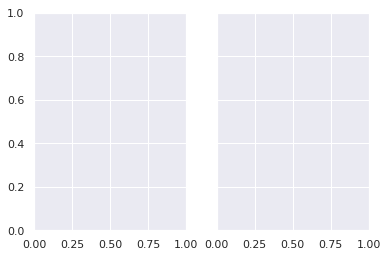

In [41]:
for TF in results_imputation['assay_dict'].keys():
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    plot_ROC(results_preimputation, TF, axes = ax1, title="no imputation")
    plot_ROC(results_imputation, TF, axes = ax2, title="imputation")
    plt.savefig(os.path.join(plot_dir, '%s_compareimputation.pdf' % TF))
    

In [4]:
import numpy as np
d2=np.load("/home/eecs/akmorrow/epitome/out/tmp/results_original.npy", allow_pickle=True)
d2

In [6]:
results_clp=np.load("/home/eecs/akmorrow/epitome/out/tmp/results_clp.npy", allow_pickle=True)
results_clp

array({'preds_mean': array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), 'preds_std': array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), 'truth': array([[ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0., -1., ...,  0.,  0., -1.]], dtype=float32), 'weights': array([[1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 